# Installation

## B1 - Create base environment with dependencies
conda create --name=pyvorotomo python=3.8 cython h5py mpi4py numpy pandas pytables scipy \
conda activate pyvorotomo \
pip install KDEpy
## B2 - Install PyKonal
git clone git@github.com:malcolmw/pykonal.git \
cd pykonal \
pip install .
## B3 - Install PyVoroTomo
git clone git@github.com:HongjianFang/PyVoroTomo.git \
cd PyVoroTomo \
pip install .

# Input data
## events and phase data file, station file

In [10]:
import pandas as pd

arrivals = pd.read_hdf('inputdata/scecdc1000eventsandphase.h5',key='arrivals')
events = pd.read_hdf('inputdata/scecdc1000eventsandphase.h5',key='events')

In [15]:
events.head()

,event_id,latitude,longitude,depth,time,residual
297834,38226808,33.493167,-116.790833,3.49,1.532180e+09,NaN
290013,38044887,33.492167,-116.796833,3.10,1.535884e+09,NaN
331232,38644703,35.672667,-117.471000,4.33,1.564097e+09,NaN
341296,38951904,35.647667,-117.451667,2.46,1.565441e+09,NaN
312742,38494399,35.711833,-117.531500,11.70,1.562637e+09,NaN


In [17]:
arrivals.head()

,network,station,event_id,phase,time,residual,snr
132256,AZ,BZN,37208884,P,1.551749e+09,NaN,NaN
138380,AZ,BZN,37266146,P,1.529576e+09,NaN,NaN
138486,AZ,BZN,37266602,P,1.529624e+09,NaN,NaN
138893,AZ,BZN,37268442,P,1.529838e+09,NaN,NaN
138989,AZ,BZN,37268930,P,1.529904e+09,NaN,NaN


In [18]:
stations = pd.read_hdf('inputdata/stations_sub.h5',key='stations')

In [20]:
stations.head()

,network,station,latitude,longitude,elevation,starttime,endtime
753,AZ,BZN,33.491501,-116.667000,1.301,4.118688e+08,<NA>
778,AZ,CPE,32.888901,-117.105103,0.150,1.083629e+09,<NA>
780,AZ,CRY,33.565399,-116.737297,1.128,4.022784e+08,<NA>
781,AZ,CSLB,33.779300,-118.112600,0.017,1.041379e+09,1278979199.0
782,AZ,CSLB,33.779900,-118.112300,0.017,1.345162e+09,1568246399.0


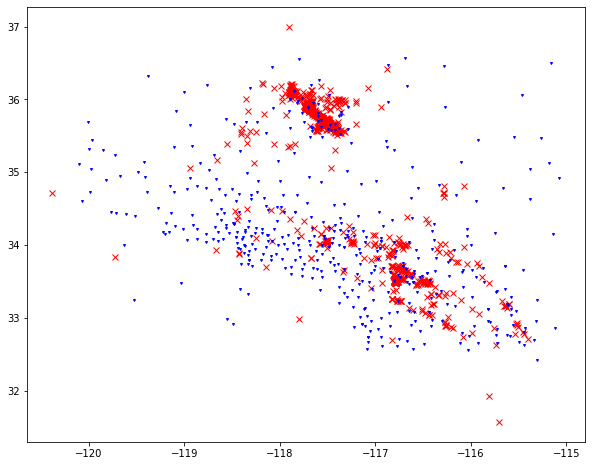

In [29]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(events['longitude'],events['latitude'],'rx')
plt.plot(stations['longitude'],stations['latitude'],'bv',markersize=2.0)

# Initial model

In [31]:
import pykonal

pmodel = pykonal.fields.read_hdf('inputdata/initial_pwave_model_berg1d.h5')

In [35]:
mincoord = pykonal.transformations.sph2geo(pmodel.min_coords)
maxcoord = pykonal.transformations.sph2geo(pmodel.max_coords)

In [41]:
mincoord,maxcoord

(array([  36.8, -120.3,   40. ]), array([  32.2, -114.7,   -4. ]))

In [39]:
pmodel.values.shape

(40, 200, 250)

Text(0.5, 0, 'Vp')

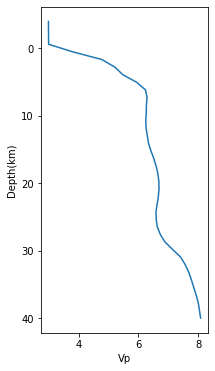

In [48]:
import numpy as np
depth = np.linspace(40,-4,40)
vel1d = pmodel.values[:,1,1]
plt.figure(figsize=(3,6))
plt.plot(vel1d,depth)
plt.gca().invert_yaxis()
plt.ylabel('Depth(km)')
plt.xlabel('Vp')

# Now we have all input prepared

mpiexec -n 4 pyvorotomo -c pyvorotomo_SoCal.cfg ../inputdata/scecdc1000eventsandphase.h5 ../inputdata/stations_sub.h5 -s ./temp

# After about half an hour
# We can plot our model at different depths

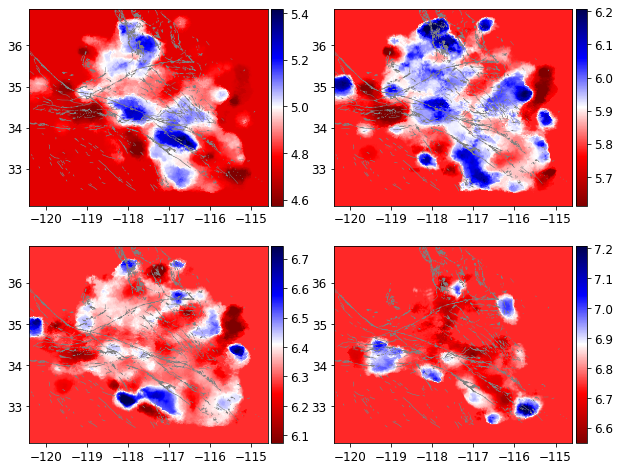

In [18]:
# %load scripts/plotmodel.py
#/* -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
#
# File Name : plotmodel.py
#
# Purpose :
#
# Creation Date : 27-05-2020
#
# Last Modified : Sat 30 Jan 2021 11:06:48 PM EST
#
# Created By : Hongjian Fang: hfang@mit.edu
#
#_._._._._._._._._._._._._._._._._._._._._.*/

import pykonal
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

modeldir = 'output_20210810T170223'
pmodelfile = 'run/'+modeldir+'/01.pwave_model.h4.0.h5'
pmodel = pykonal.fields.read_hdf(pmodelfile)

mincoord = pykonal.transformations.sph2geo(pmodel.min_coords)
maxcoord = pykonal.transformations.sph2geo(pmodel.max_coords)

npts = pmodel.npts
lat = np.linspace(mincoord[0],maxcoord[0],npts[1])
lon = np.linspace(mincoord[1],maxcoord[1],npts[2])
depth =  np.linspace(mincoord[2],maxcoord[2],npts[0])
pltdepth = np.array([1,5,10,20])
calfault = np.loadtxt('scripts/cal_faults.dat')
vmin = 4.5
vmax = 7.0
vmin = 3.0
vmax = 4.5

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
#cax = fig.add_axes([0.2,0.05,0.4,0.02])

idx = np.argmin(abs(depth-pltdepth[0]))
model = pmodel.values[idx,:,:]
vmin = model.min()+0.1
vmax = model.max()-0.1
im1 = ax[0,0].imshow(model,cmap='seismic_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[0,0].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[0,0].set_xlim([lon.min(), lon.max()])
ax[0,0].set_ylim([lat.min(), lat.max()])
#plt.colorbar(im1,ax = ax[0,0])
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')


idx = np.argmin(abs(depth-pltdepth[1]))
model = pmodel.values[idx,:,:]
vmin = model.min()+0.1
#vmax = vmin+0.5
#vmax = 3.5
vmax = model.max()-0.1
im1 = ax[0,1].imshow(model,cmap='seismic_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[0,1].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[0,1].set_xlim([lon.min(), lon.max()])
ax[0,1].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

idx = np.argmin(abs(depth-pltdepth[2]))
model = pmodel.values[idx,:,:]
vmin = model.min()+0.1
##vmax = vmin+0.5
vmax = model.max()-0.1
im1 = ax[1,0].imshow(model,cmap='seismic_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[1,0].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[1,0].set_xlim([lon.min(), lon.max()])
ax[1,0].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

idx = np.argmin(abs(depth-pltdepth[3]))
model = pmodel.values[idx,:,:]
vmin = model.min()+0.1
##vmax = vmin+0.5
vmax = model.max()-0.1
im1 = ax[1,1].imshow(model,cmap='seismic_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[1,1].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[1,1].set_xlim([lon.min(), lon.max()])
ax[1,1].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

# plt.savefig(pmodelfile+'.png',bbox_inches='tight',dpi=100)



# We can also plot uncertainty

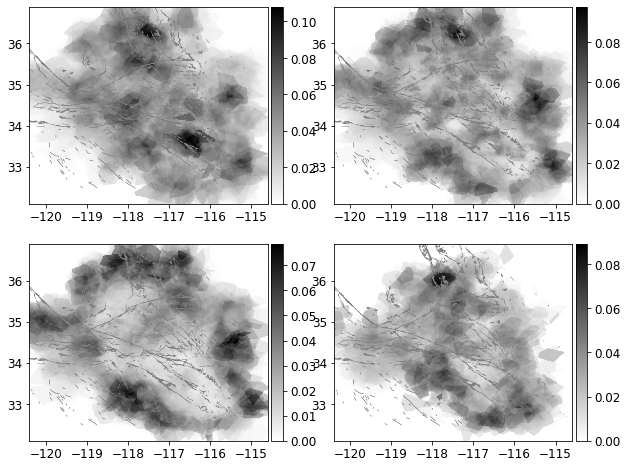

In [20]:

pmodelfile = 'run/'+modeldir+'/01.pwave_model.h4.0.h5'
vp = pykonal.fields.read_hdf(pmodelfile)
pmodelfile = 'run/'+modeldir+'/01.pwave_variance.h4.0.h5'
pmodel = pykonal.fields.read_hdf(pmodelfile)

mincoord = pykonal.transformations.sph2geo(pmodel.min_coords)
maxcoord = pykonal.transformations.sph2geo(pmodel.max_coords)

npts = pmodel.npts
lat = np.linspace(mincoord[0],maxcoord[0],npts[1])
lon = np.linspace(mincoord[1],maxcoord[1],npts[2])
depth =  np.linspace(mincoord[2],maxcoord[2],npts[0])
pltdepth = np.array([1,5,10,20])
calfault = np.loadtxt('scripts/cal_faults.dat')
vmin = 5.0
vmax = 7.5
#vmin = 3.0
#vmax = 4.5

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
#cax = fig.add_axes([0.2,0.05,0.4,0.02])
pmodel.values = pmodel.values*vp.values*vp.values
idx = np.argmin(abs(depth-pltdepth[0]))
model = pmodel.values[idx,:,:]
model = np.sqrt(model)
vmin = model.min()#+0.1
#vmax = vmin+0.5
vmax = model.max()#-0.1
im1 = ax[0,0].imshow(model,cmap='gray_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[0,0].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[0,0].set_xlim([lon.min(), lon.max()])
ax[0,0].set_ylim([lat.min(), lat.max()])
#plt.colorbar(im1,ax = ax[0,0])
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')


idx = np.argmin(abs(depth-pltdepth[1]))
model = pmodel.values[idx,:,:]
model = np.sqrt(model)
vmin = model.min()#+0.1
#vmax = vmin+0.5
vmax = model.max()#-0.1
im1 = ax[0,1].imshow(model,cmap='gray_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[0,1].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[0,1].set_xlim([lon.min(), lon.max()])
ax[0,1].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

idx = np.argmin(abs(depth-pltdepth[2]))
model = pmodel.values[idx,:,:]
model = np.sqrt(model)
vmin = model.min()#+0.1
#vmax = vmin+0.5
vmax = model.max()#-0.1
im1 = ax[1,0].imshow(model,cmap='gray_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[1,0].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[1,0].set_xlim([lon.min(), lon.max()])
ax[1,0].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

idx = np.argmin(abs(depth-pltdepth[3]))
model = pmodel.values[idx,:,:]
model = np.sqrt(model)
vmin = model.min()#+0.1
#vmax = vmin+0.5
vmax = model.max()#-0.1
im1 = ax[1,1].imshow(model,cmap='gray_r',extent=(lon.min(),lon.max(),lat.min(),lat.max()),vmin=vmin,vmax=vmax)
ax[1,1].plot(calfault[:,0],calfault[:,1],'gray',linewidth=0.5)
ax[1,1].set_xlim([lon.min(), lon.max()])
ax[1,1].set_ylim([lat.min(), lat.max()])
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)#, orientation='vertical')

# plt.savefig(pmodelfile+'.png',bbox_inches='tight',dpi=100)



# we can output our model to different formats 
dep,lat,lon,vp,vs
...

python outputmodel.py

# Earthquake locations

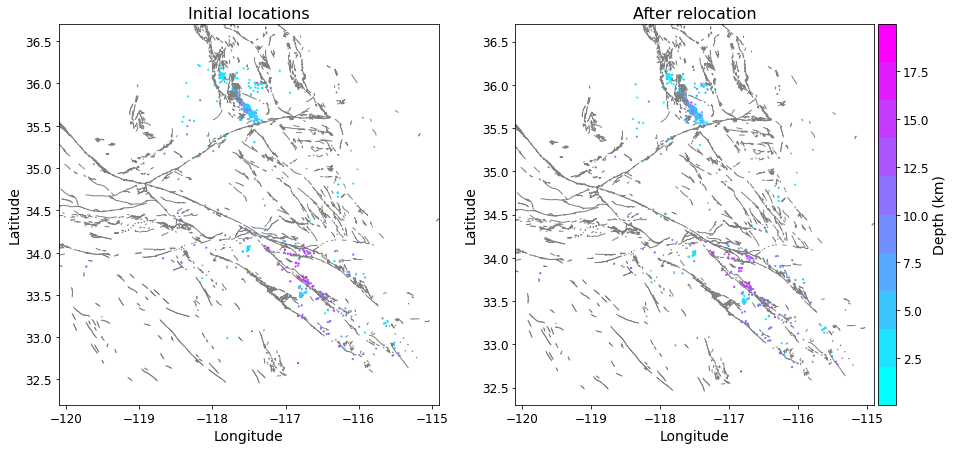

In [21]:
# %load scripts/plotreloc.py
#/* -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
#
# File Name : plotreloc.py
#
# Purpose :
#
# Creation Date : 02-06-2020
#
# Last Modified : Fri 28 Aug 2020 11:02:54 PM EDT
#
# Created By : Hongjian Fang: hfang@mit.edu
#
#_._._._._._._._._._._._._._._._._._._._._.*/

import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
import numpy as np
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

events0 = pd.read_hdf('run/'+modeldir+'/00.events.h5',key='events')
events1 = pd.read_hdf('run/'+modeldir+'/02.events.h5',key='events')
events0['type'] = 'loc'
events1['type'] = 'reloc'
eventsall = pd.concat([events0,events1],ignore_index=True)

#fig = plt.figure()
#sns.scatterplot(x='longitude',y='latitude',style='type',data=eventsall,sizes=[0.1,0.1],markers=['x','+'],hue='type')
#fig.show()
cmap = plt.cm.get_cmap('cool',10)
calfault = np.loadtxt('scripts/cal_faults.dat')
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7))
events0 = events0[(events0['depth']>0) & (events0['depth']<20)]
ax[0].scatter(events0['longitude'],events0['latitude'],s=1.4,c=events0['depth'],cmap=cmap)
ax[0].plot(calfault[:,0],calfault[:,1],'gray',linewidth=1.0)
#sns.scatterplot(x='longitude',y='latitude',hue='depth',data=events0,marker='.',cmap='jet')
ax[0].set_xlim([-120.1,-114.9])
ax[0].set_ylim([32.2,36.7])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Initial locations',fontsize=16)
# rect = patches.Rectangle((-116.2,33.6),1.2,-1.3,linewidth=1,edgecolor='r',facecolor='none')
#rect = patches.Rectangle((-118.2,34.8),1.0,-1.4,linewidth=1,edgecolor='b',facecolor='none')
#ax.add_patch(rect)
#fig.show()
#plt.savefig('InitLoc.png',bbox_inches='tight',dpi=600)

#fig = plt.figure()
events1 = events1[(events1['depth']>0) & (events1['depth']<20)]
#sns.scatterplot(x='longitude',y='latitude',hue='depth',data=events1,marker='+')
im = ax[1].scatter(events1['longitude'],events1['latitude'],s=1.4,c=events1['depth'],cmap=cmap)
ax[1].plot(calfault[:,0],calfault[:,1],'gray',linewidth=1.0)
ax[1].set_xlim([-120.1,-114.9])
ax[1].set_ylim([32.3,36.7])
# ax[1].add_patch(rect)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('After relocation',fontsize=16)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, orientation='vertical')
cbar.set_label('Depth (km)')
#fig.show()
# plt.savefig('ReLoc.png',bbox_inches='tight',dpi=600)
